In [1]:
# pip install shapely

In [5]:
import pandas as pd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import collections
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Task 1:
__Write a python class called ProcessGameState that will accomplish the following:__
1. __Handle file ingestion and ETL (if deemed necessary)__
2. __Return whether or not each row falls within a provided boundary__
    - __Be as efficient as possible (minimize runtime)__
    - __Reduce dependencies outside of standard Python libraries unless you can prove significant improvements.__
3. __Extract the weapon classes from the inventory json column__

In [6]:
class ProcessGameState:
    def __init__(self, filename):
        self.data = self._load_data(filename)
        self.polygon = Polygon([[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580]])
        self.weapon_classes = set()

    def _load_data(self, filename):
        return pd.read_parquet(filename)

    def is_within_boundary(self):
        points = [Point(x, y) for x, y in zip(self.data["x"], self.data["y"])]
        self.data["is_within_boundary"] = [self.polygon.contains(point) for point in points]

    def extract_weapon_classes(self):
        for _, row in self.data.iterrows():
            if row["inventory"] is not None:
                for i in row['inventory']:
                    if 'weapon_class' in i:
                        self.weapon_classes.add(i['weapon_class'])
        return list(self.weapon_classes)


In [7]:
# Instantiate the ProcessGameState class with the parquet file
df = ProcessGameState('game_state_frame_data.parquet')

# Check if a specific coordinate is within the boundary
df.is_within_boundary()

# Extract weapon classes from the inventory column
weapon_classes = df.extract_weapon_classes()
print(weapon_classes)  # List of weapon classes


['SMG', 'Pistols', 'Rifle', 'Grenade']


## Solution Explanation:

- The class ProcessGameState is initialized with a filename parameter, which represents the file containing the game state data. The constructor initializes the instance variables data, polygon, and weapon_classes.

- The _load_data method is a private helper function that loads the game state data from a Parquet file using the pandas read_parquet function. The loaded data is stored in the data instance variable.

- The is_within_boundary method checks if each data point (x, y coordinates) in the loaded game state data is within the specified boundary polygon. It creates a list of Point objects using the x and y coordinates from the data and checks if each point is within the polygon using the contains method of the Polygon object. The result is stored in a new column named "is_within_boundary" in the data DataFrame.

- The extract_weapon_classes method iterates over each row of the data DataFrame and extracts the weapon classes from the "inventory" column.

## Task 2 (a):

__Is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?__

In [8]:
def is_common_strategy(side, team):
    df1 = df.data.loc[(df.data["side"] == side) & (df.data["team"] == team)]

    entered_count = len(df1[df1["is_within_boundary"] == True])
    not_entered_count = len(df1[df1["is_within_boundary"] == False])
    print("No. of datapoints which are inside boundary for Team2 in T side:", entered_count) 
    print("No. of datapoints which are outside boundary for Team2 in T side:", not_entered_count)
    # Entering via the light blue boundary does not seem like common strategy used by Team2 on T (terrorist) side.

    rounds_entered_inside_boundary = df1[df1["is_within_boundary"] == True]["round_num"].unique()
    print("Rounds Team2 entered inside Boundary:", rounds_entered_inside_boundary)
    
    players_entered = collections.defaultdict(set)


    for i in rounds_entered_inside_boundary:
        df_filtered = df1.loc[(df1["round_num"] == i) & (df1["is_within_boundary"] == True)]
        for _, row in df_filtered.iterrows():
            players_entered[i].add(row["player"])
    print("Players entered the boundary in each of these rounds:", players_entered)
        
    rounds_entered_inside_BombsiteB = df1[df1["area_name"] == "BombsiteB"]["round_num"].unique()
    rounds_entered_inside_BombsiteA = df1[df1["area_name"] == "BombsiteA"]["round_num"].unique()
    print("Rounds Team2 entered BombsiteB:", rounds_entered_inside_BombsiteB)
    print("Rounds Team2 entered BombsiteA:", rounds_entered_inside_BombsiteA)

In [9]:
is_common_strategy("T", "Team2")

No. of datapoints which are inside boundary for Team2 in T side: 578
No. of datapoints which are outside boundary for Team2 in T side: 54332
Rounds Team2 entered inside Boundary: [16 17 22 24 23]
Players entered the boundary in each of these rounds: defaultdict(<class 'set'>, {16: {'Player9', 'Player5'}, 17: {'Player6', 'Player9', 'Player8'}, 22: {'Player6'}, 24: {'Player6', 'Player9'}, 23: {'Player8'}})
Rounds Team2 entered BombsiteB: [16 21 25 26 28 30]
Rounds Team2 entered BombsiteA: [22 24 17 23]


## Solution Explanation

Team 2 in T (terrorist) side entered the light blue boundary in 5 out of 15 rounds (16, 17, 22, 23, 24).

In each of these rounds:-
- __Round_16:__ Player5 and Player9 entered via the light blue boundary.
- __Round_17:__ Player8, Player6 and Player9 entered via the light blue boundary.
- __Round_22:__ Only Player6 entered via the light blue boundary.
- __Round_23:__ Only Player8 entered via the light blue boundary.
- __Round_24:__ Player6 and Player9 entered via the light blue boundary.

So, we can conclude that entering via the light blue boundary is not a common strategy used by Team2 on T (terrorist) side as:
- Players entered the light blue boundary in only 5 out of 15 rounds, and only in one round(Round 17) more than 2 players entered the boundary. 
- It might not be a team strategy to enter via the light blue boundary and one or players are entering via the boundary to create an off angle or lurk to catch the opponents off guard.


## Task 2(b):

__What is the average timer that Team2 on T (terrorist) side enters “BombsiteB” with least 2 rifles or SMGs?__

In [10]:
# Convert clock time in the format MM:SS to seconds
def convert_clock_time_to_seconds(clock_time):
    time = list(map(int, clock_time.split(":")))
    return time[0]*60 + time[1]

def get_average_timer(side, team, area_name):
    # Filter the data based on provided conditions
    df2 = df.data.loc[(df.data["side"] == side) & (df.data["team"] == team) &\
                      (df.data["area_name"] == area_name) & (df.data["bomb_planted"] == False)]

    # Create a defaultdict to store rounds and Players clock timer and weapon classes in that round
    rounds = collections.defaultdict(dict)
    for i in df2.values:
        if i[21] not in rounds[i[0]].keys():
            weapon_class = []
            if i[10] is not None:
                # Iterate over inventory items to check weapon class
                for j in i[10]:
                    if "weapon_class" in j and (j["weapon_class"] == "Rifle" or j["weapon_class"] == "SMG"):
                        weapon_class.append(j["weapon_class"])
            rounds[i[0]][i[21]] = i[15]
            if "weapon_class" in rounds[i[0]]:
                rounds[i[0]]["weapon_class"].extend(weapon_class)
            else:
                rounds[i[0]]["weapon_class"] = weapon_class

    required_clock_time = []
    # Iterate over rounds to calculate required clock times
    for i in rounds:
        if len(rounds[i]["weapon_class"]) >= 2:
            clock_time_in_seconds = []
            for j in rounds[i].keys():
                if j != "weapon_class":
                    clock_time_in_seconds.append(convert_clock_time_to_seconds(rounds[i][j]))
            required_clock_time.append(round(sum(clock_time_in_seconds)/len(clock_time_in_seconds)))

    # Calculate average timer and print the results                
    avg_timer = round(sum(required_clock_time)/len(required_clock_time))
    print("Average Timer in seconds:-", avg_timer, "seconds")
    print("Average Timer:- 0{}:{}".format(int(avg_timer/60), avg_timer - 60))

In [11]:
get_average_timer("T", "Team2", "BombsiteB")

Average Timer in seconds:- 85 seconds
Average Timer:- 01:25


## Solution Explanation: 

- The code defines a function 'get_average_timer' that calculates the average timer based on specific conditions which are (for this task), Team2 in T side for BombsiteB.
- The function takes parameters side, team, and area_name to filter the 'data' DataFrame based on these conditions.
- A defaultdict named 'rounds' is created to store information about rounds i.e. Clock timer for each player when the player enters BombsiteB for the first time and weapon classes in that round. Weapon Class is stored only if it is a 'Rifle' or 'SMG' as per requirement.
- Next, the code iterates over the rounds in the rounds dictionary and checks if a round has at least 2 weapons(either Rifle or SMG). If so, it converts the clock time to seconds for each round using the convert_clock_time_to_seconds function. The converted times are then used to calculate the average timer.

__By this approach, the average timer that Team2 on T (terrorist) side enters “BombsiteB” with least 2 rifles or SMGs comes out to be "01:25".__

## Task 2(c):

__Now that we’ve gathered data on Team2 T side, let's examine their CT (counter-terrorist) Side. Using the same data set, tell our coaching staff where you suspect them to be waiting inside “BombsiteB”.__

In [103]:
def get_suspected_location_by_scatterplot(side, team, area_name):
    df3 = df.data.loc[(df.data["side"] == side) & (df.data["team"] == team) &\
                      (df.data["area_name"] == area_name) & (df.data["bomb_planted"] == False)]
    
    players = df3["player"].unique()
    
    # Create a dictionary to map player names to colors
    player_colors = {players[0]: 'red', players[1]: 'blue', players[2]: 'green', players[3]: 'orange', players[4]: 'cyan'}  # Add more colors as needed

    # Plotting the scatter plot with different colors for each player
    plt.figure(figsize=(10, 8))
    for player, color in player_colors.items():
        player_df = df3[df3['player'] == player]
        plt.scatter(player_df['x'], player_df['y'], color=color, label=player)

    plt.title('Player Coordinates in ' + area_name)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().invert_xaxis()
    plt.legend()
    plt.show()

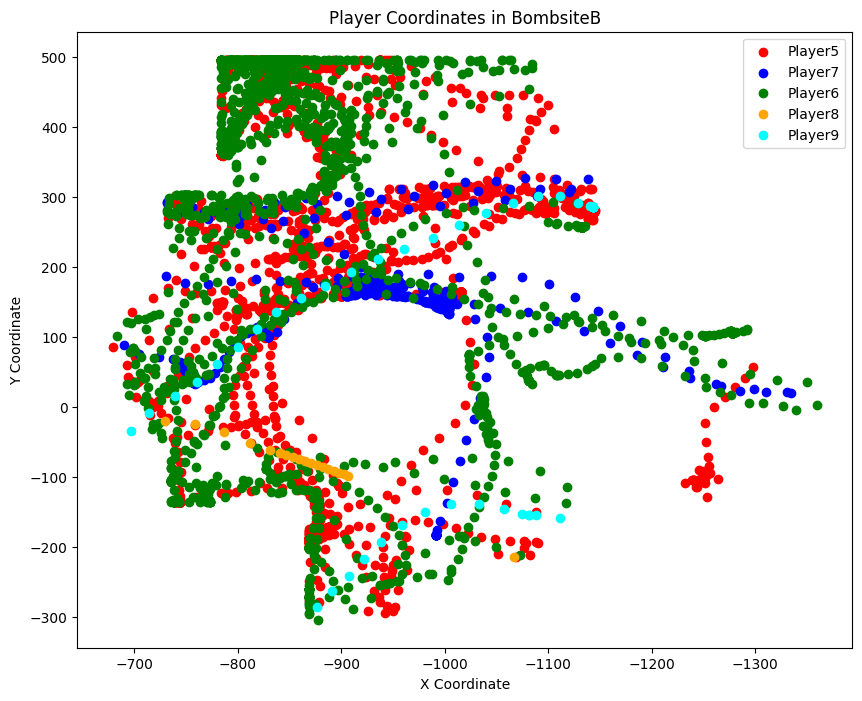

In [104]:
get_suspected_location_by_scatterplot('CT', 'Team2', 'BombsiteB')

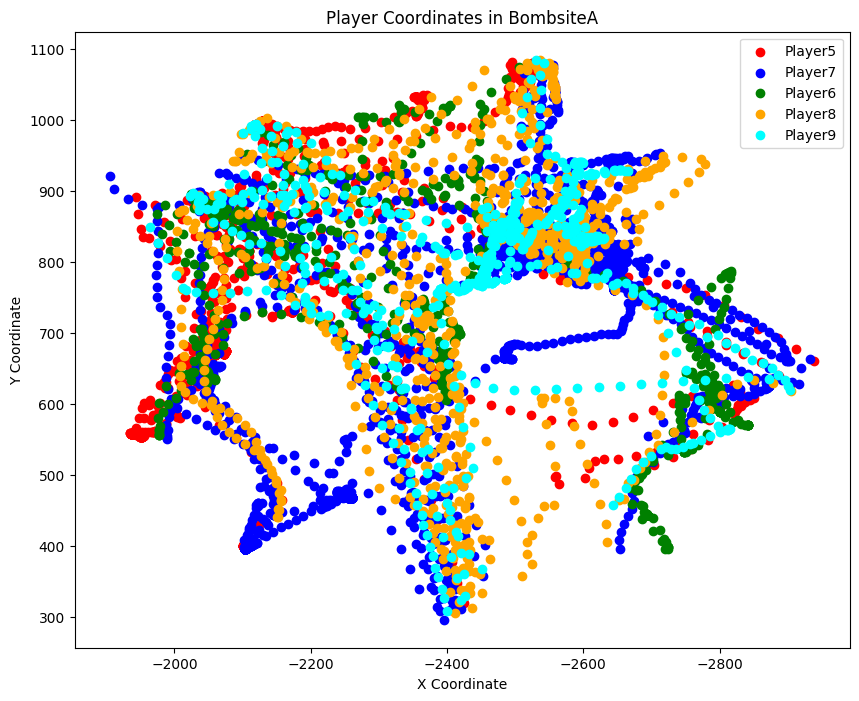

In [105]:
get_suspected_location('CT', 'Team2', 'BombsiteA')

In [109]:
def get_suspected_location_by_heatmap(side, team, area_name):
    df3 = df.data.loc[(df.data["side"] == side) & (df.data["team"] == team) & \
                      (df.data["area_name"] == area_name) & (df.data["bomb_planted"] == False)]

    # Set up the figure and axes
    fig, axs = plt.subplots(3,2, figsize=(12, 12))

    # Load the background image
    background_img = plt.imread("de_overpass_radar_cropped.jpeg")

    players = df3["player"].unique()

    for index, player in enumerate(players):
        df_player = df3[df3["player"] == player]
        # Define the number of bins and range for x and y coordinates
        num_bins = 10
        x_range = (df_player['x'].min()-100, df_player['x'].max()+100)
        y_range = (df_player['y'].min()-100, df_player['y'].max()+100)
        ax = axs[int(index/2), index%2]
        # Generate the heatmap by histogramming the data
        heatmap, xedges, yedges = np.histogram2d(df_player['x'], df_player['y'], bins=num_bins, range=[x_range, y_range])

        # Create meshgrid for coordinates
        x, y = np.meshgrid(xedges, yedges)

        # Create the heatmap using pcolormesh
        cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 'none'), (1, 'yellow')])  # Customize the colormap
        pcm = ax.pcolormesh(x, y, heatmap.T, cmap=cmap)

        # Add colorbar
        cbar = plt.colorbar(pcm, ax=ax)

        # Overlay the background image
        ax.imshow(background_img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], aspect='auto')


        # Set labels and title
        ax.set_xlabel('X-coordinate')
        ax.set_ylabel('Y-coordinate')
        ax.set_title(player + ' Position Heatmap on ' + area_name)
#         plt.gca().invert_xaxis()

    fig.tight_layout()
    # Show the plot
    plt.show()

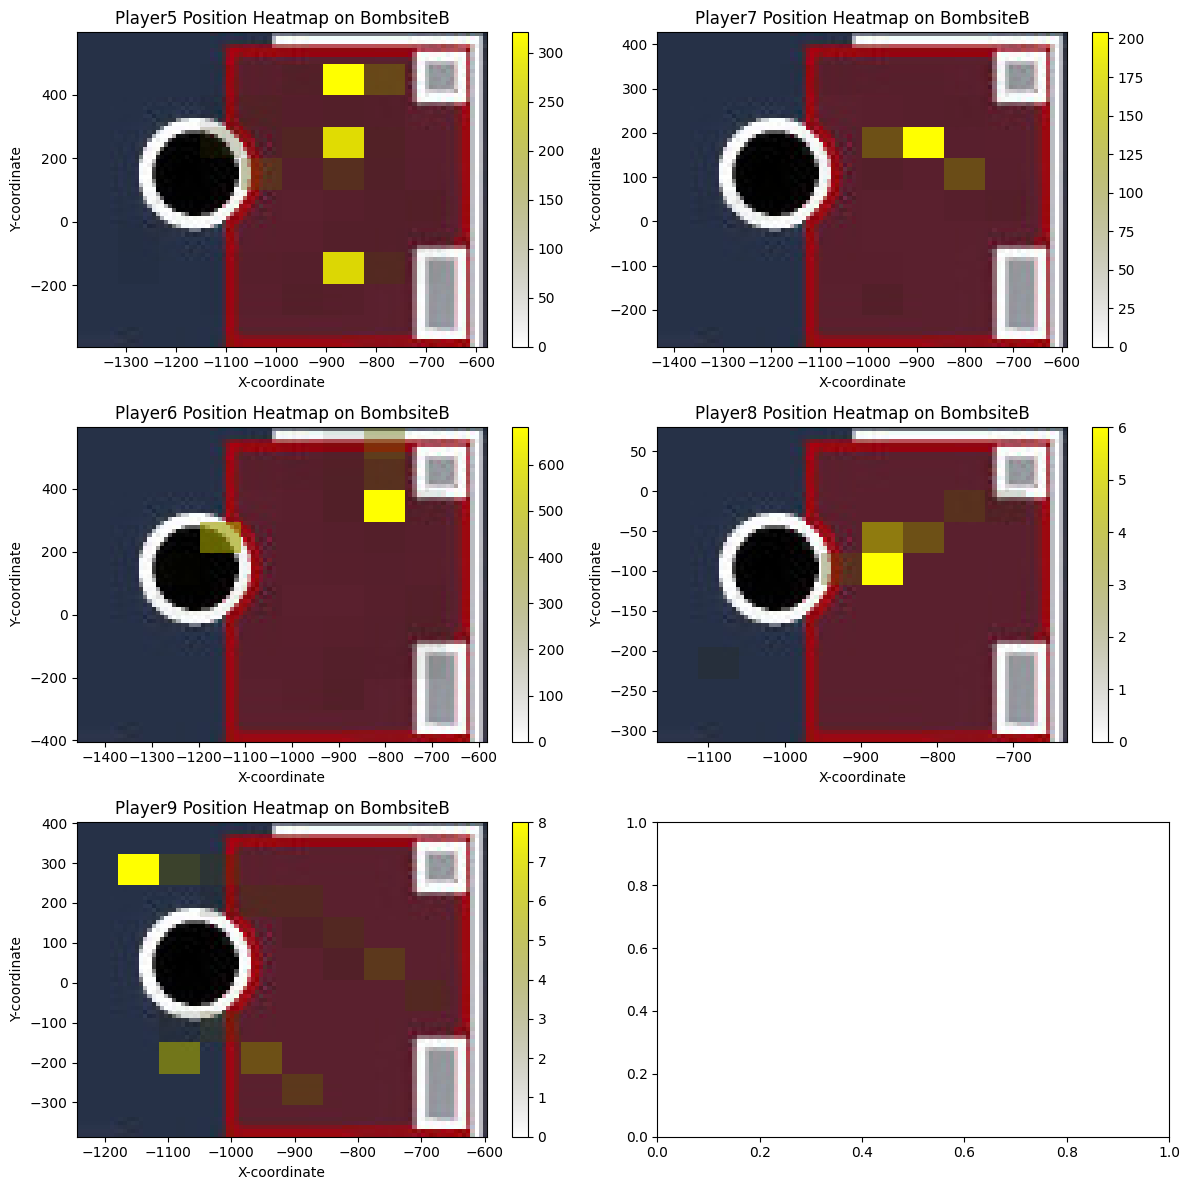

In [112]:
get_suspected_location_by_heatmap("CT", "Team2", "BombsiteB")

## Solution Explanation:

- The code defines a function 'get_suspected_location_by_scatterplot' and 'get_suspected_location_by_heatmap' that plots the graphs based on specific conditions which are (for this task), Team2 in CT side for BombsiteB.
- The function takes parameters side, team, and area_name to filter the 'data' DataFrame based on these conditions.
- In get_suspected_location_by_scatterplot, Each player in the team is assigned a color in 'player_colors' dict to distinguish them in the plots.
- A scatter plot is plotted using the coodinates in the filtered DataFrame to identify the positions of the players inside Bombsite and suspect their position based on the density of the each player's coordinates.

- In get_suspected_location_by_heatmap, an individual heatmap has been plotted for each player of the team using the coodinates in the filtered DataFrame to identify the positions of the players inside Bombsite and suspect their position based on the density of the each player's coordinates.
- Density of the yellow color can be used to identify the suspected position of the player inside Bombsite. 
- Colorbar beside each heatmap can be used to understand the mapping between the numeric values in the heatmap and the colors used to represent them.

### Observation: 
- Player5, Player6 are suspected to be waiting inside BombsiteB. 
- Player8, Player9 are suspected to play more inside BombsiteA. 
- Player7 might be waiting on either of those Bombsites.
- Player5, Player6 are suspected to be waiting in the top part of BombsiteB.
- The Point on an individual player's heatmap, where the density is highest can be a suspected position of the player inside BombsiteB. 
- For Player8 and Player9, Colorbar shows that there are very less number of coordinates on BombsiteB, indicating that Player8 and Player9 are suspected to be waiting in BombsiteA.

## Task:  
__Most of the time, our stakeholders (in this case CS:GO coaching staff) aren't tech savvy enough to run code themselves. Propose a solution to your product manager that:__

- __Could allow our coaching staff to request or acquire the output themselves__
- __Takes less than 1 weeks worth of work to implement.__

## Proposed Solution:

To address the requirements of allowing coaching staff to request or acquire 
the output themselves and keeping the implementation within one week, I propose 
developing a web-based dashboard or application that provides an interface for the 
coaching staff to access and interact with the analysis and plots generated from the CS:GO game data.

Here's an outline of the proposed solution:

1. Dashboard/Application Design:
    - Design a user-friendly and intuitive dashboard or application interface.
    - Include features such as filters, input fields, and buttons for selecting analysis options and parameters.
    - Provide sections or tabs for different types of analysis and plots.

2. Data Integration:    
    - Build a backend system to process and analyze the CS:GO game data.
    - Implement the existing analysis code within the backend system.
    - Ensure the backend can handle the data processing efficiently.

3. API Development:
    - Create APIs (Application Programming Interfaces) to expose the analysis functionality 
    - and data retrieval to the frontend.
    - Define API endpoints for receiving requests from the dashboard/application.

4. Frontend Development:
    - Develop the frontend of the dashboard/application using web technologies (HTML, CSS, JavaScript, etc.).
    - Utilize frameworks or libraries (e.g., React, Angular, Vue.js) to facilitate interactive and dynamic components.
    - Integrate the APIs to retrieve analysis results and display them in the dashboard/application.

5. Security and Access Control:
    - Implement user authentication and authorization mechanisms to ensure only authorized coaching staff can access the
    - dashboard/application.
    - Set up appropriate security measures, such as encryption and secure communication protocols, to protect
sensitive data.

6. Deployment and Testing:
    - Deploy the backend system and frontend dashboard/application to a web server or cloud platform.
    - Conduct thorough testing to ensure the dashboard/application functions correctly and provides accurate analysis results.

7. Documentation and Training:
    - Create user documentation or guides explaining how to use the dashboard/application.
    - Provide training sessions or workshops to familiarize the coaching staff with the dashboard/application's features and functionalities.


By implementing this solution, the coaching staff will have an accessible and user-friendly interface
to request and acquire the analysis and plots generated from the CS:GO game data. They can interact
with the dashboard/application without the need for technical knowledge or running code themselves.

With careful planning and efficient development, it is feasible to complete the implementation 
of the dashboard/application within a week. However, the exact timeline may vary depending on the complexity
of the existing codebase and the specific requirements of the dashboard/application.